<a href="https://colab.research.google.com/github/darshanvjani/Extensive-Vision-AI-Program-EVAI6-/blob/main/5_Architecture_Finetuning(CodingDrillDown)/Architecture_Finetuning(Best_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR

# Data Transformtions

In [3]:
from torchvision.transforms.transforms import RandomRotation,RandomAffine
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.40, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                      
])
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
])

# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data',train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data',train=False, download=True,transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [5]:
SEED = 10

# cuda? 

cuda = torch.cuda.is_available()
print("Cuda Available?", cuda)

#for reproducability
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader args
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Cuda Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


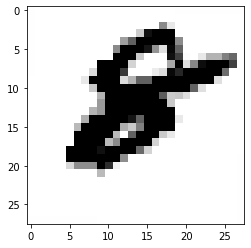

In [6]:
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('Statistics!')
# print(' - Numpy Shape:',train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:',train.train_data.size())
# print(' -  min:',torch.min(train_data))
# print(' -  max:',torch.max(train_data))
# print(' -  mean:',torch.mean(train_data))
# print(' -  std:',torch.std(train_data))
# print(' -  var:',torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')




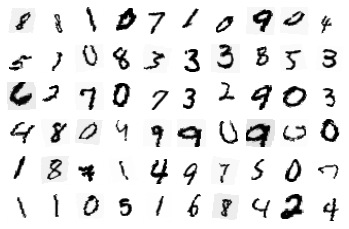

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1block = nn.Sequential(    # 28 -> 26 | RF:3
            nn.Conv2d(1,10,3,padding=0,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.03)
        )
        self.conv2block = nn.Sequential(    # 26 -> 24 | RF:5
            nn.Conv2d(10,17,3,padding=0,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(17),
            nn.Dropout2d(0.03)
        )
        # self.conv3block = nn.Sequential(    # 24 -> 22 | RF:7
        #     nn.Conv2d(16,32,3,padding=0,bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(32),
        #     nn.Dropout2d(0.07)
        # )
        
        self.pool1 = nn.MaxPool2d(2,2)    # 24 -> 12 | RF:10
        
        self.trans1block = nn.Sequential(    # 12 -> 10 | RF:12
            nn.Conv2d(17,10,1,padding=0,bias=False),
            nn.ReLU()
        )

        self.conv4block = nn.Sequential(    # 10 -> 8 | RF:14
            nn.Conv2d(10,18,3,padding=0,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout2d(0.03)
        )
        self.conv5block = nn.Sequential(    # 8 -> 6 | RF:16
            nn.Conv2d(18,18,3,padding=0,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout2d(0.03)
        )
        self.conv6block = nn.Sequential(    # 6 -> 4 | RF:18
            nn.Conv2d(18,18,3,padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout2d(0.03)
        )

        self.outputblock = nn.Sequential(    # 4 -> 1 | RF:18
            nn.AvgPool2d(6),
            nn.Conv2d(18,20,1,padding=0,bias=False),
            nn.ReLU(),
            nn.Conv2d(20,10,1,padding=0,bias=False)
        )

    def forward(self, x):
        x = self.conv1block(x)
        x = self.conv2block(x)
        x = self.pool1(x)
        x = self.trans1block(x)
        x = self.conv4block(x)
        x = self.conv5block(x)
        x = self.conv6block(x)
        x = self.outputblock(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 17, 24, 24]           1,530
              ReLU-6           [-1, 17, 24, 24]               0
       BatchNorm2d-7           [-1, 17, 24, 24]              34
         Dropout2d-8           [-1, 17, 24, 24]               0
         MaxPool2d-9           [-1, 17, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             170
             ReLU-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 18, 10, 10]           1,620
             ReLU-13           [-1, 18, 10, 10]               0
      BatchNorm2d-14           [-1

# Training and Testing

In [22]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and Test our model

In [23]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.013,epochs=15,steps_per_epoch=len(train_loader))
EPOCHS = 15

for epoch in range(EPOCHS):
  print("EPOCH:",epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.6682826280593872 Batch_id=468 Accuracy=23.45: 100%|██████████| 469/469 [00:41<00:00, 11.38it/s]



Test set: Average loss: 1.5570, Accuracy: 3883/10000 (38.83%)

EPOCH: 1


Loss=0.4846579134464264 Batch_id=468 Accuracy=70.15: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.2076, Accuracy: 9466/10000 (94.66%)

EPOCH: 2


Loss=0.19920183718204498 Batch_id=468 Accuracy=91.29: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0693, Accuracy: 9801/10000 (98.01%)

EPOCH: 3


Loss=0.14082710444927216 Batch_id=468 Accuracy=94.27: 100%|██████████| 469/469 [00:35<00:00, 13.09it/s]



Test set: Average loss: 0.0431, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.1542326807975769 Batch_id=468 Accuracy=95.43: 100%|██████████| 469/469 [00:35<00:00, 13.03it/s]



Test set: Average loss: 0.0393, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.1613573580980301 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]



Test set: Average loss: 0.0316, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.09961395710706711 Batch_id=468 Accuracy=96.32: 100%|██████████| 469/469 [00:36<00:00, 12.94it/s]



Test set: Average loss: 0.0264, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.12238547205924988 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.0316, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.04143929481506348 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]



Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.03253311663866043 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:36<00:00, 13.01it/s]



Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.12235209345817566 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:36<00:00, 12.98it/s]



Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.058140743523836136 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s]



Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.06728477030992508 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s]



Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.03447423502802849 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]



Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.097104012966156 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

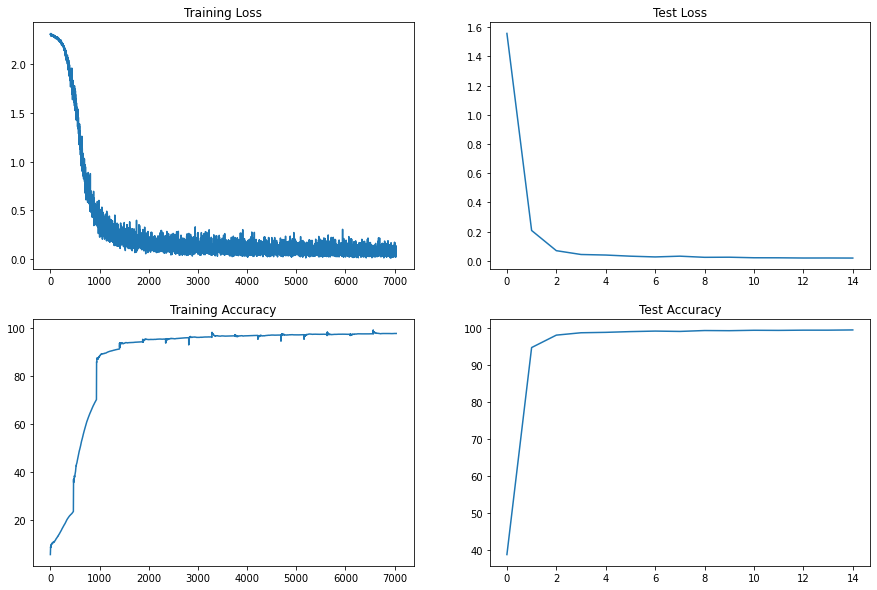

In [43]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

# train_losses = [x.cpu() for x in train_losses]
# train_losses = [x.detach().numpy() for x in train_losses]

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")